### BERT

In [1]:
import sys
print(sys.executable)

/root/miniconda3/envs/bert/bin/python


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
----------


评估中: 100%|██████████| 56/56 [00:15<00:00,  3.65it/s]


训练损失: 0.5561, 训练准确率: 0.8414
验证损失: 0.3776, 验证准确率: 0.8889
最佳模型已保存至 best_bert_model.pt

Epoch 2/5
----------


评估中: 100%|██████████| 56/56 [00:16<00:00,  3.30it/s]


训练损失: 0.2615, 训练准确率: 0.9246
验证损失: 0.3372, 验证准确率: 0.9017
最佳模型已保存至 best_bert_model.pt

Epoch 3/5
----------


评估中: 100%|██████████| 56/56 [00:15<00:00,  3.51it/s]


训练损失: 0.1480, 训练准确率: 0.9601
验证损失: 0.3535, 验证准确率: 0.9023
最佳模型已保存至 best_bert_model.pt

Epoch 4/5
----------


评估中: 100%|██████████| 56/56 [00:15<00:00,  3.67it/s]


训练损失: 0.0797, 训练准确率: 0.9781
验证损失: 0.3693, 验证准确率: 0.9068
最佳模型已保存至 best_bert_model.pt

Epoch 5/5
----------


评估中: 100%|██████████| 56/56 [00:15<00:00,  3.68it/s]


训练损失: 0.0478, 训练准确率: 0.9878
验证损失: 0.3813, 验证准确率: 0.9034


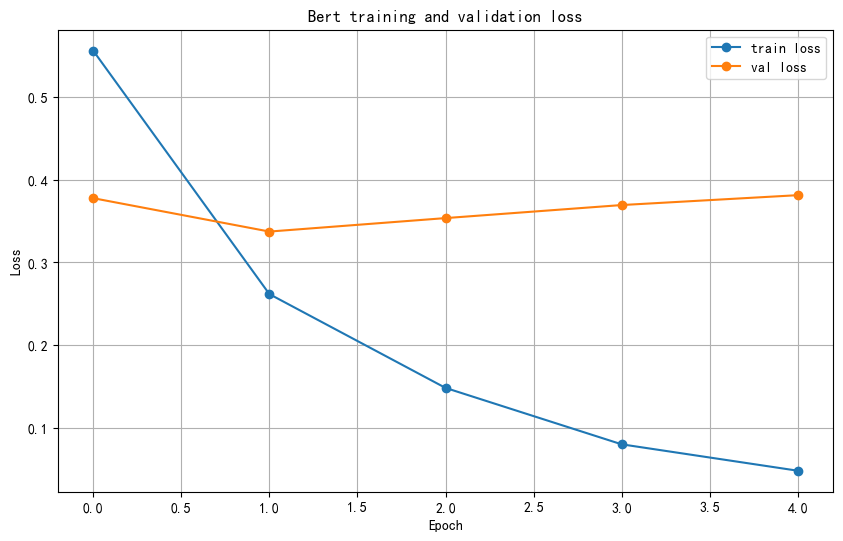

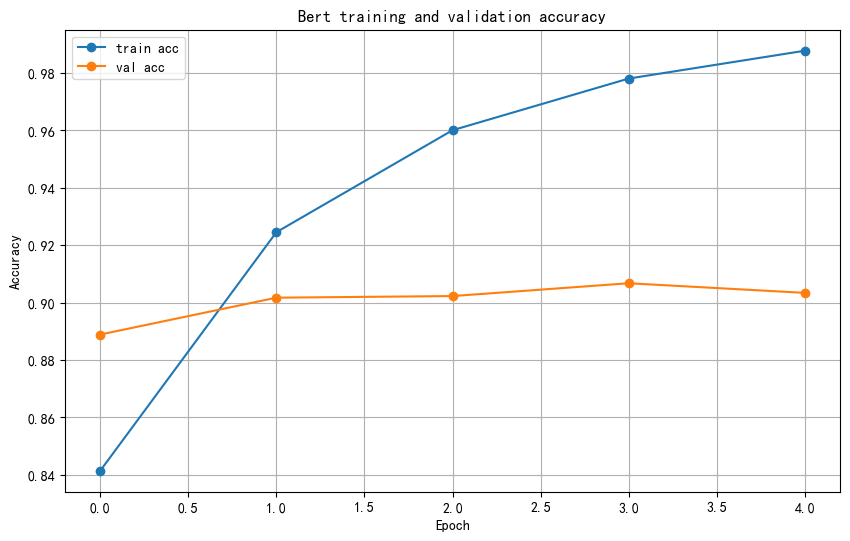

评估中: 100%|██████████| 56/56 [00:16<00:00,  3.35it/s]



测试损失: 0.3332, 测试准确率: 0.9090

分类报告:
              precision    recall  f1-score   support

     Culture     0.8656    0.8090    0.8364       199
   Education     0.8788    0.8744    0.8766       199
     Finance     0.9122    0.9397    0.9257       199
      Health     0.9115    0.8794    0.8951       199
          IT     0.8696    0.9045    0.8867       199
    Military     0.9596    0.9548    0.9572       199
     Recruit     0.8621    0.8794    0.8706       199
      Sports     0.9850    0.9899    0.9875       199
      Travel     0.9356    0.9497    0.9426       199

    accuracy                         0.9090      1791
   macro avg     0.9089    0.9090    0.9087      1791
weighted avg     0.9089    0.9090    0.9087      1791



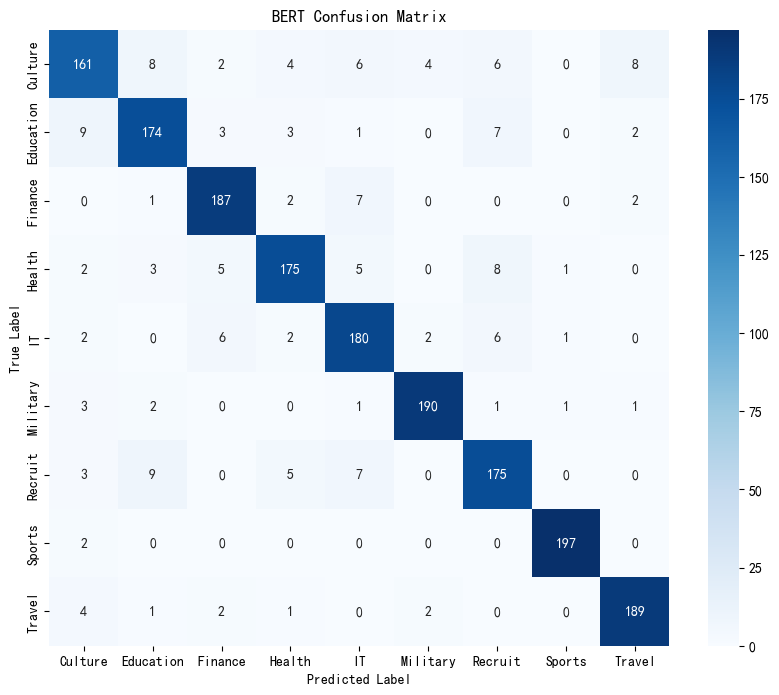

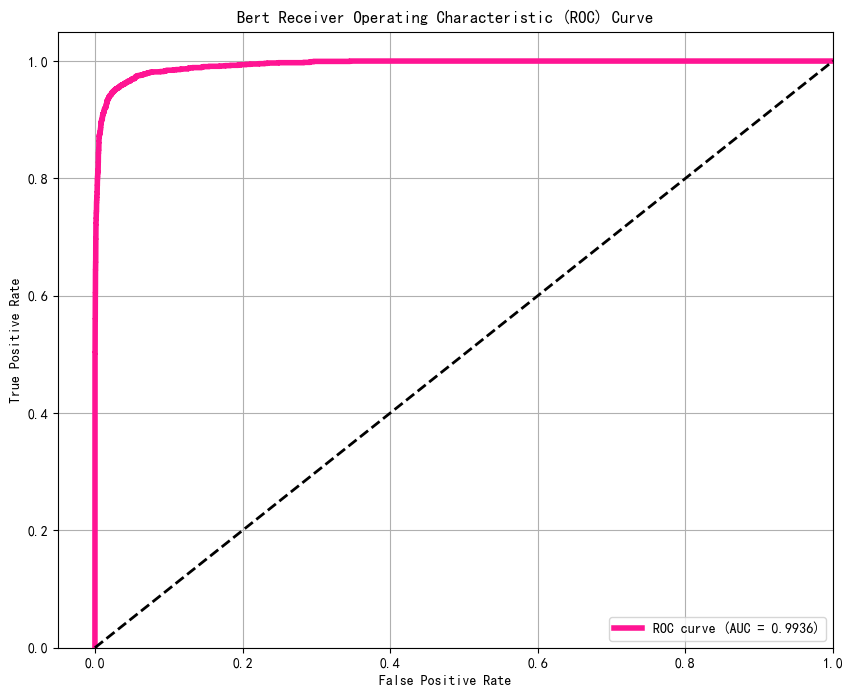

In [2]:
import os
import re
from colorama import Fore
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings

from matplotlib import font_manager

# 加载字体文件
font_path = '/root/autodl-tmp/test/simhei.ttf'  
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

# 设置全局字体
plt.rcParams['font.family'] = prop.get_name()



# 配置
warnings.filterwarnings('ignore')  # 忽略警告信息
# plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False  # 防止负号显示问题

# 定义数据集类，继承自Dataset
class CommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, stopwords, max_len=128):
        """
        数据集初始化，包括文本数据、标签、tokenizer、停用词表以及最大长度设置
        """
        self.tokenizer = tokenizer  # 使用的BERT tokenizer
        self.texts = texts  # 输入文本
        self.labels = labels  # 输入标签
        self.stopwords = stopwords  # 停用词
        self.max_len = max_len  # 最大长度，超过会截断，短于会填充

    def __len__(self):
        """
        返回数据集的大小
        """
        return len(self.texts)

    def preprocess_text(self, text):
        """
        对文本进行预处理，包括去除停用词和特殊字符
        """
        text = re.sub(r'[^A-Za-z0-9\u4e00-\u9fa5]+', ' ', text)  # 只保留中文字符和英文、数字
        text = text.strip()  # 去除两端空格
        words = text.split()  # 按空格分词
        words = [word for word in words if word not in self.stopwords]  # 去除停用词
        return ' '.join(words)  # 重新组合文本

    def __getitem__(self, idx):
        """
        获取数据集中的一个样本，返回处理后的input_ids、attention_mask和label
        """
        text = self.texts[idx]
        text = self.preprocess_text(text)  # 预处理文本
        encoding = self.tokenizer.encode_plus(
            str(text),
            max_length=self.max_len,  # 截断或填充至最大长度
            padding='max_length',  # 填充
            truncation=True,  # 截断
            return_attention_mask=True,  # 返回attention_mask
            return_tensors='pt'  # 返回Pytorch tensor格式
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx] if self.labels is not None else -1, dtype=torch.long)
        }

# 定义BERT分类器类
class BERTClassifier:
    def __init__(self, model_name='bert-base-chinese', num_labels=None, batch_size=32, max_len=128, stopwords_file=None):
        """
        初始化BERT分类器，加载预训练模型和tokenizer
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 使用GPU或者CPU
        self.tokenizer = BertTokenizer.from_pretrained(model_name)  # 加载tokenizer
        self.batch_size = batch_size  # 批量大小
        self.max_len = max_len  # 最大长度
        self.model_name = model_name  # 模型名称
        self.num_labels = num_labels  # 标签数
        self.label_encoder = LabelEncoder()  # 标签编码器，用于将标签转换为数字
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}  # 训练过程中的历史记录
        self.best_val_acc = 0  # 保存最佳验证准确率
        
        self.stopwords = set()  # 停用词集合
        if stopwords_file:
            with open(stopwords_file, encoding='utf-8') as f:
                self.stopwords = set(f.read().strip().splitlines())  # 从文件加载停用词

    def prepare_data(self, data_dir):
        """
        准备数据集，读取文本数据并划分训练集、验证集和测试集
        """
        texts = []
        labels = []

        # 使用文件夹名称作为标签
        for folder in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder)
            if os.path.isdir(folder_path):
                for filename in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, filename)
                    with open(file_path, encoding='gbk', errors='ignore') as f:
                        texts.append(f.read())  # 读取文件内容
                        labels.append(folder)  # 文件夹名称作为标签

        # 标签编码
        self.label_encoder.fit(labels)
        encoded_labels = self.label_encoder.transform(labels)

        # 划分数据集为训练集、验证集和测试集
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )

        # 创建数据加载器
        self.train_loader = DataLoader(
            CommentDataset(X_train, y_train, self.tokenizer, self.stopwords, self.max_len),
            batch_size=self.batch_size, shuffle=True
        )
        self.val_loader = DataLoader(
            CommentDataset(X_val, y_val, self.tokenizer, self.stopwords, self.max_len),
            batch_size=self.batch_size
        )
        self.test_loader = DataLoader(
            CommentDataset(X_test, y_test, self.tokenizer, self.stopwords, self.max_len),
            batch_size=self.batch_size
        )

        self.num_labels = len(self.label_encoder.classes_)  # 标签类别数

        # 初始化BERT模型
        self.model = BertForSequenceClassification.from_pretrained(
            self.model_name, num_labels=self.num_labels
        ).to(self.device)

    def train_epoch(self, optimizer, scheduler):
        """
        训练一个epoch
        """
        self.model.train()  # 设置模型为训练模式
        total_loss = 0
        correct = 0
        total = 0

        # 遍历训练数据加载器
        for batch in tqdm(self.train_loader, desc="训练中"):
            optimizer.zero_grad()  # 梯度清零
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            # 前向传播
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            # 预测
            _, preds = torch.max(outputs.logits, dim=1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

            loss.backward()  # 反向传播
            optimizer.step()  # 更新参数
            scheduler.step()  # 更新学习率

        # 返回损失和准确率
        return total_loss / len(self.train_loader), correct.double() / total

    def evaluate(self, data_loader):
        """
        在验证集或测试集上进行评估
        """
        self.model.eval()  # 设置模型为评估模式
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        # 不计算梯度
        with torch.no_grad():
            for batch in tqdm(data_loader, desc="评估中"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                total_loss += outputs.loss.item()

                # 预测
                _, preds = torch.max(outputs.logits, dim=1)
                correct += torch.sum(preds == labels)
                total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # 返回评估结果
        return (
            total_loss / len(data_loader),
            correct.double() / total,
            all_preds,
            all_labels
        )

    def train(self, epochs=5, save_path='best_bert_model.pt'):
        """
        训练模型
        """
        optimizer = AdamW(self.model.parameters(), lr=3e-5)  # 使用AdamW优化器
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(self.train_loader) * epochs
        )

        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print("-" * 10)

            train_loss, train_acc = self.train_epoch(optimizer, scheduler)  # 训练一个epoch
            val_loss, val_acc, _, _ = self.evaluate(self.val_loader)  # 在验证集上评估

            print(f"训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.4f}")
            print(f"验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.4f}")

            # 记录训练过程
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc.cpu().numpy())
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc.cpu().numpy())

            # 保存最佳模型
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), save_path)
                print(f"最佳模型已保存至 {save_path}")

    def plot_training_history(self):
        """
        绘制训练过程中的损失和准确率变化图
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_loss'], marker='o', label='train loss')
        plt.plot(self.history['val_loss'], marker='o', label='val loss')
        plt.title('Bert training and validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_acc'], marker='o', label='train acc')
        plt.plot(self.history['val_acc'], marker='o', label='val acc') 
        plt.title('Bert training and validation accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate_and_plot(self, model_path='best_bert_model.pt'):
        """
        评估测试集并绘制相关图表
        """
        self.model.load_state_dict(torch.load(model_path))  # 加载保存的最佳模型
        self.model.to(self.device)
        self.model.eval()

        test_loss, test_acc, y_pred, y_true = self.evaluate(self.test_loader)  # 在测试集上评估
        print(f"\n测试损失: {test_loss:.4f}, 测试准确率: {test_acc:.4f}")

        # 转换回原始标签（文件夹名称）
        y_pred_labels = self.label_encoder.inverse_transform(y_pred)
        y_true_labels = self.label_encoder.inverse_transform(y_true)

        # 打印分类报告
        print("\n分类报告:")
        print(classification_report(y_true_labels, y_pred_labels, digits=4, target_names=self.label_encoder.classes_))

        # 混淆矩阵
        cm = confusion_matrix(y_true_labels, y_pred_labels, labels=self.label_encoder.classes_)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('BERT Confusion Matrix')
        plt.show()

        # 绘制ROC曲线
        probs = []
        with torch.no_grad():
            for batch in self.test_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                probs.append(torch.softmax(outputs.logits, dim=1).cpu().numpy())

        test_probs = np.concatenate(probs)
        y_test_bin = label_binarize(y_true, classes=range(self.num_labels))

        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_probs.ravel())
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})',
                 color='deeppink', linewidth=4)
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Bert Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

if __name__ == '__main__':
    data_dir = '/root/autodl-tmp/test/cn_news'  # 数据目录
    stopwords_file = '/root/autodl-tmp/test/baidu_stopwords.txt'  # 停用词文件
    classifier = BERTClassifier(stopwords_file=stopwords_file)  # 初始化BERT分类器
    classifier.prepare_data(data_dir)  # 准备数据
    classifier.train(epochs=5, save_path='best_bert_model.pt')  # 训练模型
    classifier.plot_training_history()  # 绘制训练历史图
    classifier.evaluate_and_plot(model_path='best_bert_model.pt')  # 评估测试集并绘图


## BERT-CNN


Epoch 1/5
----------


评估中: 100%|██████████| 56/56 [00:15<00:00,  3.71it/s]


训练损失: 0.5416, 训练准确率: 0.8354
验证损失: 0.3717, 验证准确率: 0.8844
最佳模型已保存至 best_bert_cnn_model.pt

Epoch 2/5
----------


评估中: 100%|██████████| 56/56 [00:15<00:00,  3.71it/s]


训练损失: 0.2334, 训练准确率: 0.9281
验证损失: 0.3462, 验证准确率: 0.8995
最佳模型已保存至 best_bert_cnn_model.pt

Epoch 3/5
----------


评估中: 100%|██████████| 56/56 [00:15<00:00,  3.68it/s]


训练损失: 0.1052, 训练准确率: 0.9678
验证损失: 0.3688, 验证准确率: 0.9040
最佳模型已保存至 best_bert_cnn_model.pt

Epoch 4/5
----------


评估中: 100%|██████████| 56/56 [00:15<00:00,  3.70it/s]


训练损失: 0.0412, 训练准确率: 0.9877
验证损失: 0.3992, 验证准确率: 0.9095
最佳模型已保存至 best_bert_cnn_model.pt

Epoch 5/5
----------


评估中: 100%|██████████| 56/56 [00:14<00:00,  3.73it/s]


训练损失: 0.0175, 训练准确率: 0.9945
验证损失: 0.4265, 验证准确率: 0.9095


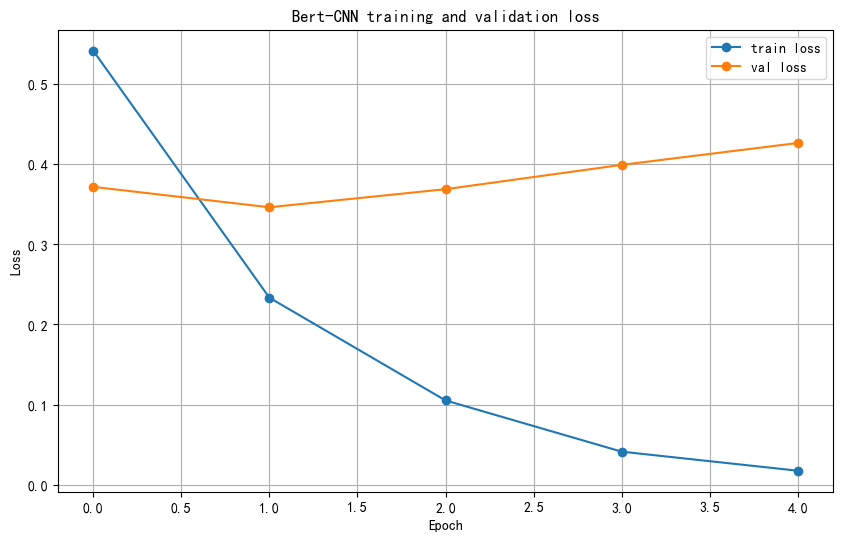

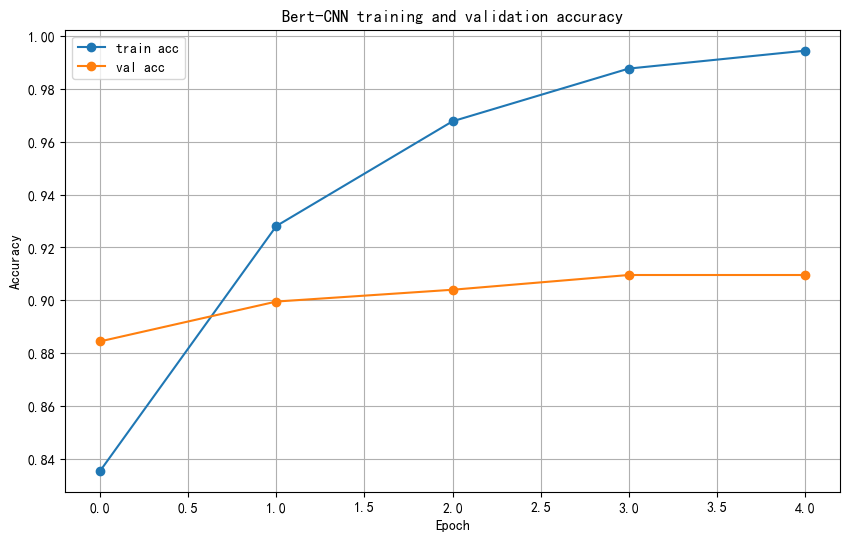

评估中: 100%|██████████| 56/56 [00:14<00:00,  3.76it/s]



测试损失: 0.3478, 测试准确率: 0.9129

分类报告:
              precision    recall  f1-score   support

     Culture     0.8291    0.8291    0.8291       199
   Education     0.9096    0.8593    0.8837       199
     Finance     0.9163    0.9347    0.9254       199
      Health     0.9141    0.9095    0.9118       199
          IT     0.8673    0.9196    0.8927       199
    Military     0.9794    0.9548    0.9669       199
     Recruit     0.8844    0.8844    0.8844       199
      Sports     0.9850    0.9899    0.9875       199
      Travel     0.9347    0.9347    0.9347       199

    accuracy                         0.9129      1791
   macro avg     0.9133    0.9129    0.9129      1791
weighted avg     0.9133    0.9129    0.9129      1791



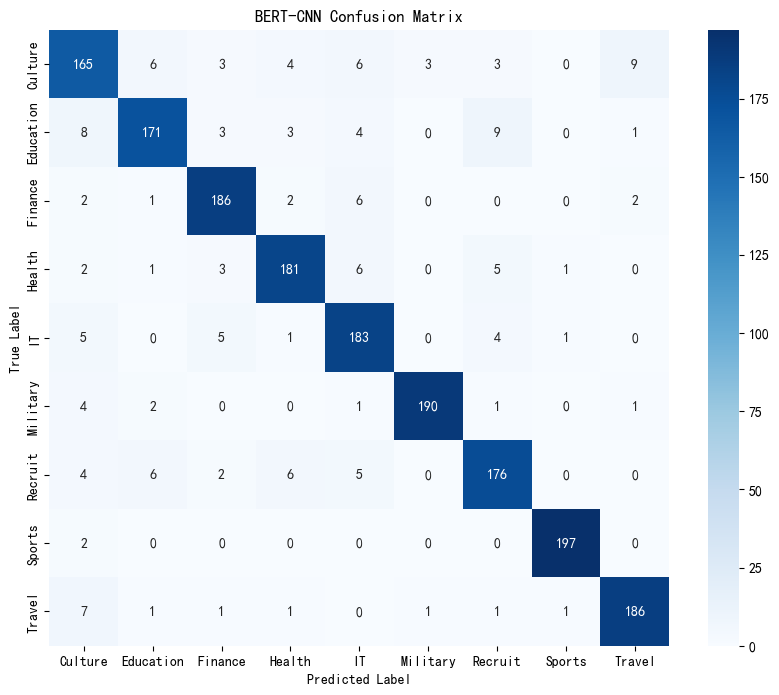

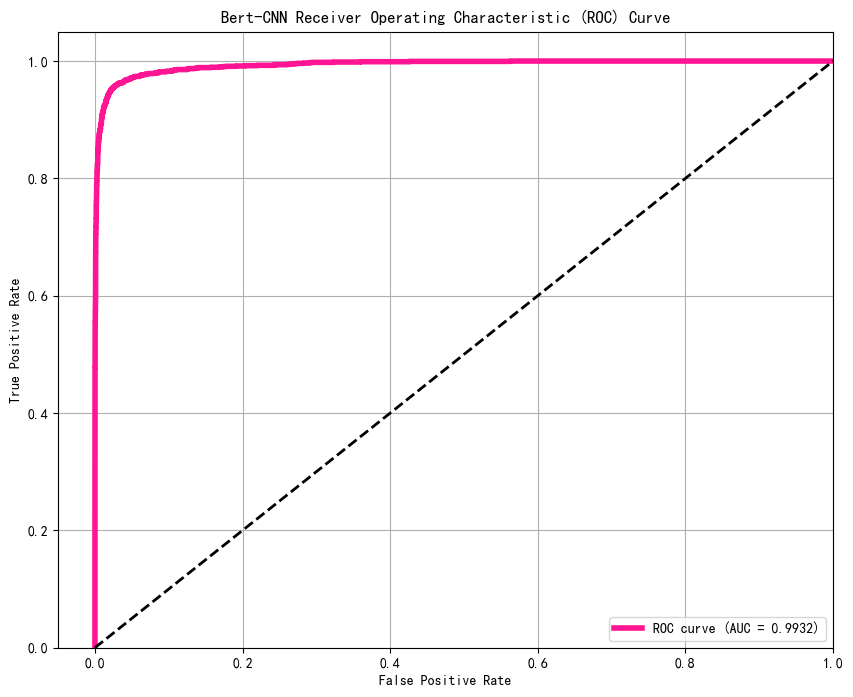

In [2]:
import os
import re
from colorama import Fore
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings

from matplotlib import font_manager

# 加载字体文件
font_path = '/root/autodl-tmp/test/simhei.ttf'  # 确保路径正确
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

# 设置全局字体
plt.rcParams['font.family'] = prop.get_name()

# 配置
warnings.filterwarnings('ignore')  # 忽略警告
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文显示
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 数据集类
class CommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, stopwords, max_len=128):
        """
        初始化数据集类，包括输入文本、标签、tokenizer、停用词和最大长度
        """
        self.tokenizer = tokenizer  # 使用的BERT tokenizer
        self.texts = texts  # 文本数据
        self.labels = labels  # 标签
        self.stopwords = stopwords  # 停用词
        self.max_len = max_len  # 文本最大长度

    def __len__(self):
        """返回数据集的大小"""
        return len(self.texts)

    def preprocess_text(self, text):
        """
        对文本进行预处理，包括去除停用词和特殊字符
        """
        text = re.sub(r'[^A-Za-z0-9\u4e00-\u9fa5]+', ' ', text)  # 只保留中文、英文和数字字符
        text = text.strip()  # 去除两端空白字符
        words = text.split()  # 以空格为分隔符分词
        words = [word for word in words if word not in self.stopwords]  # 去除停用词
        return ' '.join(words)  # 返回清洗后的文本

    def __getitem__(self, idx):
        """
        获取数据集中的一个样本，进行文本预处理并返回相关张量
        """
        text = self.texts[idx]  # 获取文本
        text = self.preprocess_text(text)  # 进行预处理

        # 对文本进行tokenize，并返回input_ids、attention_mask和标签
        encoding = self.tokenizer.encode_plus(
            str(text),
            max_length=self.max_len,  # 截断或填充至最大长度
            padding='max_length',  # 填充至最大长度
            truncation=True,  # 截断
            return_attention_mask=True,  # 返回attention mask
            return_tensors='pt'  # 返回Pytorch tensor格式
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),  # 返回flatten的input_ids
            'attention_mask': encoding['attention_mask'].flatten(),  # 返回flatten的attention_mask
            'labels': torch.tensor(self.labels[idx] if self.labels is not None else -1, dtype=torch.long)  # 返回标签
        }

# BERT-CNN模型定义
class BERTCNNClassifier(nn.Module):
    def __init__(self, bert_model_name, num_labels, hidden_size=768, dropout=0.1):
        """
        初始化BERT-CNN模型，BERT用于提取特征，CNN用于进行进一步的特征学习
        """
        super(BERTCNNClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)  # 加载BERT预训练模型
        self.conv = nn.Conv1d(in_channels=hidden_size, out_channels=256, kernel_size=3)  # 定义1D卷积层
        self.relu = nn.ReLU()  # ReLU激活函数
        self.pool = nn.MaxPool1d(kernel_size=2)  # 最大池化层
        self.fc = nn.Linear(256 * ((128 - 3 + 1) // 2), num_labels)  # 全连接层
        self.dropout = nn.Dropout(dropout)  # Dropout层，防止过拟合

    def forward(self, input_ids, attention_mask):
        """
        前向传播函数
        """
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)  # BERT模型的输出
        sequence_output = outputs.last_hidden_state  # 提取BERT的最后一层隐藏状态
        x = sequence_output.transpose(1, 2)  # 转置维度以适应CNN的输入
        x = self.conv(x)  # 卷积操作
        x = self.relu(x)  # ReLU激活
        x = self.pool(x)  # 池化操作
        x = x.view(x.size(0), -1)  # 展平卷积层输出
        x = self.dropout(x)  # Dropout层
        return self.fc(x)  # 返回经过全连接层的输出

# 分类器封装类
class BERTCNNClassifierWrapper:
    def __init__(self, model_name='bert-base-chinese', num_labels=None, batch_size=32, max_len=128, stopwords_file=None):
        """
        初始化BERT-CNN分类器封装类
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 判断是否使用GPU
        self.tokenizer = BertTokenizer.from_pretrained(model_name)  # 加载BERT tokenizer
        self.batch_size = batch_size  # 设置批量大小
        self.max_len = max_len  # 设置最大长度
        self.model_name = model_name  # 设置模型名称
        self.num_labels = num_labels  # 设置标签数量
        self.label_encoder = LabelEncoder()  # 标签编码器，用于将标签转化为数字
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}  # 记录训练历史
        self.best_val_acc = 0  # 保存最佳验证准确率
        
        # 加载停用词
        self.stopwords = set()  # 停用词集合
        if stopwords_file:
            with open(stopwords_file, encoding='utf-8') as f:
                self.stopwords = set(f.read().strip().splitlines())

    def prepare_data(self, data_dir):
        """
        加载和准备数据，包括文本读取、标签编码和数据集划分
        """
        texts = []
        labels = []

        # 遍历数据文件夹，读取文本和标签
        for folder in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder)
            if os.path.isdir(folder_path):
                for filename in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, filename)
                    with open(file_path, encoding='gbk', errors='ignore') as f:
                        texts.append(f.read())  # 添加文本数据
                        labels.append(folder)  # 标签为文件夹名称

        # 标签编码
        self.label_encoder.fit(labels)  # 根据标签训练编码器
        encoded_labels = self.label_encoder.transform(labels)  # 将标签转换为数字

        # 划分数据集为训练集、验证集和测试集
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )

        # 创建数据加载器
        self.train_loader = DataLoader(
            CommentDataset(X_train, y_train, self.tokenizer, self.stopwords, self.max_len),
            batch_size=self.batch_size, shuffle=True
        )
        self.val_loader = DataLoader(
            CommentDataset(X_val, y_val, self.tokenizer, self.stopwords, self.max_len),
            batch_size=self.batch_size
        )
        self.test_loader = DataLoader(
            CommentDataset(X_test, y_test, self.tokenizer, self.stopwords, self.max_len),
            batch_size=self.batch_size
        )

        self.num_labels = len(self.label_encoder.classes_)  # 更新标签数量

        # 初始化模型
        self.model = BERTCNNClassifier(self.model_name, self.num_labels).to(self.device)

    def train_epoch(self, optimizer, scheduler, criterion):
        """
        训练一个epoch，包括前向传播、损失计算、反向传播和优化步骤
        """
        self.model.train()  # 设置模型为训练模式
        total_loss = 0
        correct = 0
        total = 0

        # 遍历训练数据
        for batch in tqdm(self.train_loader, desc="训练中"):
            optimizer.zero_grad()  # 清零梯度
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)  # 模型前向传播
            loss = criterion(outputs, labels)  # 计算损失
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)  # 获取预测结果
            correct += torch.sum(preds == labels)  # 计算正确的样本数
            total += labels.size(0)  # 计算总样本数

            loss.backward()  # 反向传播
            optimizer.step()  # 更新优化器参数
            scheduler.step()  # 更新学习率

        # 返回每个epoch的损失和准确率
        return total_loss / len(self.train_loader), correct.double() / total

    def evaluate(self, data_loader, criterion):
        """
        评估模型的性能
        """
        self.model.eval()  # 设置模型为评估模式
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(data_loader, desc="评估中"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)  # 模型前向传播
                loss = criterion(outputs, labels)  # 计算损失
                total_loss += loss.item()

                _, preds = torch.max(outputs, dim=1)  # 获取预测结果
                correct += torch.sum(preds == labels)  # 计算正确的样本数
                total += labels.size(0)  # 计算总样本数

                all_preds.extend(preds.cpu().numpy())  # 保存预测结果
                all_labels.extend(labels.cpu().numpy())  # 保存实际标签

        # 返回评估结果
        return (
            total_loss / len(data_loader),
            correct.double() / total,
            all_preds,
            all_labels
        )

    def train(self, epochs=5, save_path='best_bert_cnn_model.pt'):
        """
        训练模型
        """
        criterion = nn.CrossEntropyLoss()  # 定义损失函数
        optimizer = AdamW(self.model.parameters(), lr=5e-5)  # 定义优化器
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(self.train_loader) * epochs
        )

        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            print("-" * 10)

            # 训练一个epoch
            train_loss, train_acc = self.train_epoch(optimizer, scheduler, criterion)
            val_loss, val_acc, _, _ = self.evaluate(self.val_loader, criterion)

            print(f"训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.4f}")
            print(f"验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.4f}")

            # 记录训练历史
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc.cpu().numpy())
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc.cpu().numpy())

            # 保存最佳模型
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), save_path)
                print(f"最佳模型已保存至 {save_path}")

    def plot_training_history(self):
        """
        绘制训练过程中的损失和准确率变化图
        """
        # 绘制损失曲线
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_loss'], marker='o', label='train loss')
        plt.plot(self.history['val_loss'], marker='o', label='val loss')
        plt.title('Bert-CNN training and validation loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        # 绘制准确率曲线
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_acc'], marker='o', label='train acc')
        plt.plot(self.history['val_acc'], marker='o', label='val acc')
        plt.title('Bert-CNN training and validation accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate_and_plot(self, model_path='best_bert_cnn_model.pt'):
        """
        评估模型并绘制分类报告、混淆矩阵、ROC曲线
        """
        self.model.load_state_dict(torch.load(model_path))  # 加载最佳模型
        self.model.to(self.device)  # 将模型移动到GPU或CPU
        self.model.eval()  # 设置模型为评估模式

        criterion = nn.CrossEntropyLoss()
        test_loss, test_acc, y_pred, y_true = self.evaluate(self.test_loader, criterion)  # 在测试集上评估
        print(f"\n测试损失: {test_loss:.4f}, 测试准确率: {test_acc:.4f}")

        # 将预测结果和真实标签转回原始标签（文件夹名称）
        y_pred_labels = self.label_encoder.inverse_transform(y_pred)
        y_true_labels = self.label_encoder.inverse_transform(y_true)

        # 输出分类报告
        print("\n分类报告:")
        print(classification_report(y_true_labels, y_pred_labels, digits=4, target_names=self.label_encoder.classes_))

        # 混淆矩阵
        cm = confusion_matrix(y_true_labels, y_pred_labels, labels=self.label_encoder.classes_)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('BERT-CNN Confusion Matrix')
        plt.show()

        # 计算ROC曲线
        probs = []
        with torch.no_grad():
            for batch in self.test_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
                probs.append(torch.softmax(outputs, dim=1).cpu().numpy())

        test_probs = np.concatenate(probs)
        y_test_bin = label_binarize(y_true, classes=range(self.num_labels))

        # 绘制ROC曲线
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_probs.ravel())
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})',
                 color='deeppink', linewidth=4)
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Bert-CNN Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

# 主程序
if __name__ == '__main__':
    data_dir = '/root/autodl-tmp/test/cn_news'  
    stopwords_file = '/root/autodl-tmp/test/baidu_stopwords.txt' 

    classifier = BERTCNNClassifierWrapper(stopwords_file=stopwords_file)  # 初始化BERT-CNN分类器
    classifier.prepare_data(data_dir)  # 准备数据
    classifier.train(epochs=5, save_path='best_bert_cnn_model.pt')  # 训练模型并保存
    classifier.plot_training_history()  # 绘制训练历史
    classifier.evaluate_and_plot(model_path='best_bert_cnn_model.pt')  # 评估并绘制结果


## Transformer

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.607 seconds.
Prefix dict has been built successfully.



Epoch 1/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 514.91it/s]


训练损失: 1.0872, 训练准确率: 0.6300
验证损失: 0.6304, 验证准确率: 0.7990
最佳模型已保存至 best_transformer_model.pt

Epoch 2/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 517.97it/s]


训练损失: 0.5468, 训练准确率: 0.8284
验证损失: 0.5375, 验证准确率: 0.8342
最佳模型已保存至 best_transformer_model.pt

Epoch 3/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 497.83it/s]


训练损失: 0.4093, 训练准确率: 0.8682
验证损失: 0.4933, 验证准确率: 0.8425
最佳模型已保存至 best_transformer_model.pt

Epoch 4/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 503.74it/s]


训练损失: 0.3065, 训练准确率: 0.9021
验证损失: 0.5213, 验证准确率: 0.8476
最佳模型已保存至 best_transformer_model.pt

Epoch 5/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 511.26it/s]


训练损失: 0.2470, 训练准确率: 0.9195
验证损失: 0.5488, 验证准确率: 0.8425

Epoch 6/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 519.70it/s]


训练损失: 0.1800, 训练准确率: 0.9428
验证损失: 0.5826, 验证准确率: 0.8398

Epoch 7/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 505.19it/s]


训练损失: 0.1427, 训练准确率: 0.9551
验证损失: 0.6368, 验证准确率: 0.8425

Epoch 8/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 517.08it/s]


训练损失: 0.1208, 训练准确率: 0.9597
验证损失: 0.6576, 验证准确率: 0.8370

Epoch 9/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 516.44it/s]


训练损失: 0.1003, 训练准确率: 0.9664
验证损失: 0.6997, 验证准确率: 0.8476

Epoch 10/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 519.51it/s]


训练损失: 0.0861, 训练准确率: 0.9716
验证损失: 0.7492, 验证准确率: 0.8386


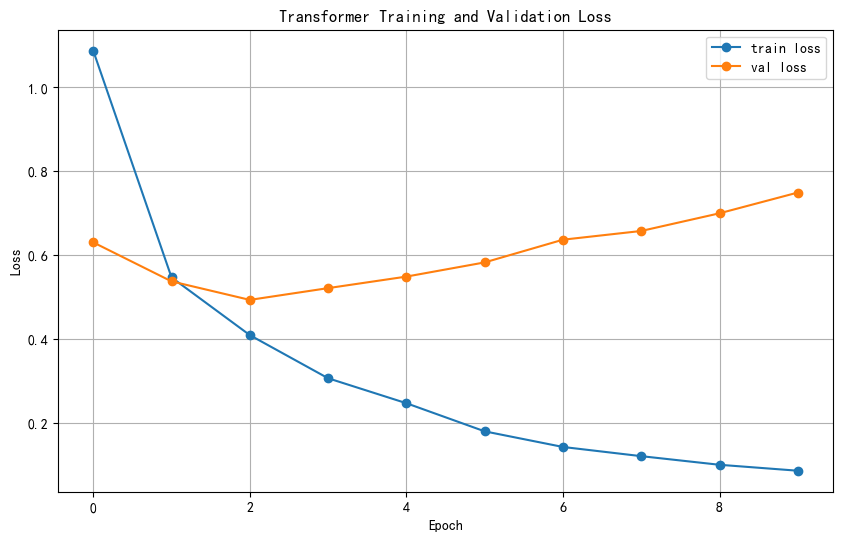

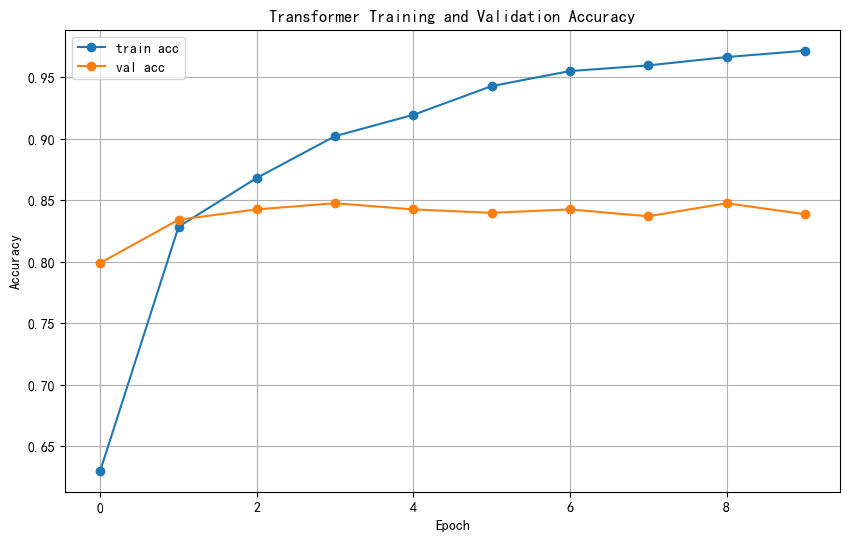

评估中: 100%|██████████| 56/56 [00:00<00:00, 507.81it/s]



测试损失: 0.5290, 测试准确率: 0.8532

分类报告:
              precision    recall  f1-score   support

     Culture     0.6713    0.7286    0.6988       199
   Education     0.8272    0.7940    0.8103       199
     Finance     0.9556    0.8643    0.9077       199
      Health     0.8833    0.7990    0.8391       199
          IT     0.8086    0.8492    0.8284       199
    Military     0.8815    0.9347    0.9073       199
     Recruit     0.8711    0.8492    0.8601       199
      Sports     0.9289    0.9849    0.9561       199
      Travel     0.8744    0.8744    0.8744       199

    accuracy                         0.8532      1791
   macro avg     0.8558    0.8532    0.8536      1791
weighted avg     0.8558    0.8532    0.8536      1791



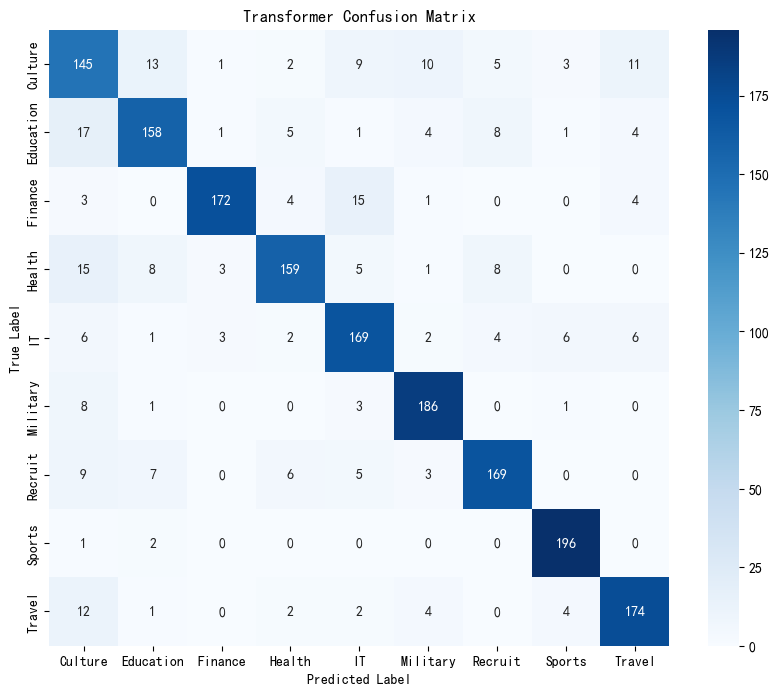

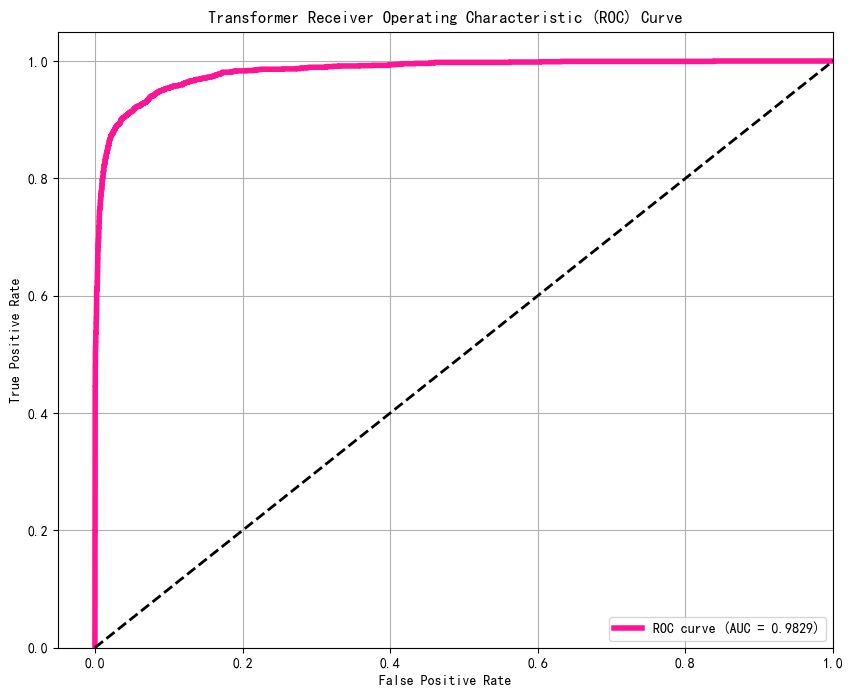

In [1]:
import os
import re
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import jieba
from collections import Counter

from matplotlib import font_manager

# 加载字体文件
font_path = '/root/autodl-tmp/test/simhei.ttf'  # 确保路径正确
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)

# 设置全局字体
plt.rcParams['font.family'] = prop.get_name()

# 配置
warnings.filterwarnings('ignore')  # 忽略警告
#plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文显示
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 文本预处理类
class TextPreprocessor:
    def __init__(self, max_features=10000, max_len=128, stopwords_file=None):
        self.max_features = max_features  # 最大词汇数
        self.max_len = max_len  # 最大文本长度
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}  # 初始化字典，<PAD>和<UNK>为特殊字符
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}  # 反向字典
        self.word_counts = Counter()  # 词频统计

        self.stopwords = set()  # 停用词
        if stopwords_file:
            # 如果提供了停用词文件，读取并存入
            with open(stopwords_file, encoding='utf-8') as f:
                self.stopwords = set(f.read().strip().splitlines())

    def clean_text(self, text):
        """清理文本"""
        text = re.sub(r'[^A-Za-z0-9\u4e00-\u9fa5]+', ' ', text)  # 去掉非字母、数字、汉字的字符
        text = text.strip()  # 去除首尾空格
        return text

    def tokenize(self, text):
        """分词并去除停用词"""
        text = self.clean_text(text)  # 清理文本
        words = jieba.lcut(str(text))  # 使用jieba进行分词
        words = [word for word in words if word not in self.stopwords]  # 去除停用词
        return words

    def fit(self, texts):
        """构建词典"""
        for text in texts:
            self.word_counts.update(self.tokenize(text))  # 统计词频
        for word, _ in self.word_counts.most_common(self.max_features - 2):  # 只保留top N个词
            idx = len(self.word2idx)
            self.word2idx[word] = idx  # 为每个词分配索引
            self.idx2word[idx] = word  # 更新索引与词的反向映射

    def text_to_sequence(self, text):
        """将文本转为序列"""
        words = self.tokenize(text)
        sequence = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in words]  # 将词转换为索引
        # 如果文本短于最大长度，补充< PAD >，如果超出则截断
        if len(sequence) < self.max_len:
            sequence = sequence + [self.word2idx['<PAD>']] * (self.max_len - len(sequence))
        else:
            sequence = sequence[:self.max_len]
        return sequence

# 数据集类
class TextDataset(Dataset):
    def __init__(self, texts, labels, preprocessor):
        self.texts = [preprocessor.text_to_sequence(text) for text in texts]  # 将文本转为序列
        self.labels = labels  # 标签

    def __len__(self):
        return len(self.texts)  # 返回数据集大小

    def __getitem__(self, idx):
        """获取数据集中一个样本"""
        return {
            'input_ids': torch.tensor(self.texts[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx] if self.labels is not None else -1, dtype=torch.long)
        }

# Transformer编码器层
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1, max_len=128):
        super().__init__()
        # 定义多头自注意力机制
        self.d_model = d_model
        self.n_heads = n_heads
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.linear1 = nn.Linear(d_model, d_ff)  # 前馈神经网络的第一层
        self.dropout = nn.Dropout(dropout)  # Dropout层
        self.linear2 = nn.Linear(d_ff, d_model)  # 前馈神经网络的第二层
        self.norm1 = nn.LayerNorm(d_model)  # 层归一化
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()  # 激活函数

    def forward(self, src):
        # 自注意力机制部分
        attn_output, attn_weights = self.self_attn(src, src, src)
        src = src + self.dropout1(attn_output)  # 残差连接
        src = self.norm1(src)  # 层归一化
        ff_output = self.linear2(self.dropout(self.activation(self.linear1(src))))  # 前馈神经网络
        src = src + self.dropout2(ff_output)  # 残差连接
        src = self.norm2(src)  # 层归一化
        return src

# Transformer模型类
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, d_ff, num_layers, num_classes, max_len=128, dropout=0.1):
        super().__init__()
        # 初始化embedding层
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, d_model))  # 位置编码
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, d_ff, dropout, max_len)
            for _ in range(num_layers)
        ])  # 堆叠多层编码器
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)  # 输出层

    def forward(self, src):
        embedded = self.embedding(src)  # 将词索引转为词向量
        embedded = embedded + self.positional_encoding[:, :src.size(1), :]  # 添加位置编码
        embedded = self.dropout(embedded)
        embedded = embedded.permute(1, 0, 2)  # 调整维度，适应多头自注意力层
        for layer in self.encoder_layers:  # 通过每一层编码器
            embedded = layer(embedded)
        embedded = embedded.permute(1, 0, 2)
        pooled = embedded.mean(dim=1)  # 对所有位置的隐藏状态进行平均池化
        out = self.fc(pooled)  # 通过全连接层得到输出
        return out

# 分类器类
class TransformerClassifier:
    def __init__(self, d_model=128, n_heads=8, d_ff=256, num_layers=2, dropout=0.1,
                 batch_size=32, max_features=10000, max_len=128, learning_rate=1e-3, 
                 epochs=10, stopwords_file=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # 判断是否使用GPU
        self.preprocessor = TextPreprocessor(max_features=max_features, max_len=max_len, stopwords_file=stopwords_file)
        self.batch_size = batch_size
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_ff = d_ff
        self.num_layers = num_layers
        self.dropout = dropout
        self.max_len = max_len
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.label_encoder = LabelEncoder()  # 标签编码器
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}  # 存储训练过程中的历史数据
        self.best_val_acc = 0  # 最佳验证准确率

    def prepare_data(self, data_dir):
        """加载和准备数据"""
        texts = []
        labels = []
        label_names = []  # 保存唯一的文件夹名称

        # 遍历数据集文件夹
        for folder in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder)
            if os.path.isdir(folder_path):
                label_names.append(folder)  # 记录类别名称
                for filename in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, filename)
                    with open(file_path, encoding='gbk', errors='ignore') as f:
                        texts.append(f.read())  # 读取文本内容
                        labels.append(folder)  # 使用文件夹名称作为标签

        # 标签编码：对唯一的文件夹名称进行编码
        self.label_encoder.fit(label_names)
        encoded_labels = self.label_encoder.transform(labels)

        # 构建词典
        self.preprocessor.fit(texts)
        vocab_size = len(self.preprocessor.word2idx)

        # 划分数据集
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )

        # 创建数据加载器
        self.train_loader = DataLoader(
            TextDataset(X_train, y_train, self.preprocessor),
            batch_size=self.batch_size, shuffle=True
        )
        self.val_loader = DataLoader(
            TextDataset(X_val, y_val, self.preprocessor),
            batch_size=self.batch_size
        )
        self.test_loader = DataLoader(
            TextDataset(X_test, y_test, self.preprocessor),
            batch_size=self.batch_size
        )

        num_classes = len(self.label_encoder.classes_)

        # 初始化模型
        self.model = TransformerModel(
            vocab_size=vocab_size,
            d_model=self.d_model,
            n_heads=self.n_heads,
            d_ff=self.d_ff,
            num_layers=self.num_layers,
            num_classes=num_classes,
            max_len=self.max_len,
            dropout=self.dropout
        ).to(self.device)

        self.criterion = nn.CrossEntropyLoss()  # 损失函数
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)  # 优化器

    def train_epoch(self):
        """训练一个epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        for batch in tqdm(self.train_loader, desc='训练中'):
            self.optimizer.zero_grad()  # 清空梯度
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['label'].to(self.device)
            outputs = self.model(input_ids)  # 模型输出
            loss = self.criterion(outputs, labels)  # 计算损失
            loss.backward()  # 反向传播
            self.optimizer.step()  # 更新参数
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # 获取预测结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return total_loss / len(self.train_loader), correct / total  # 返回平均损失和准确率

    def evaluate(self, data_loader):
        """评估模型表现"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        all_probs = []
        with torch.no_grad():  # 不计算梯度
            for batch in tqdm(data_loader, desc='评估中'):
                input_ids = batch['input_ids'].to(self.device)
                labels = batch['label'].to(self.device)
                outputs = self.model(input_ids)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        return (
            total_loss / len(data_loader),
            correct / total,
            all_preds,
            all_labels,
            np.array(all_probs)
        )

    def train_model(self, save_path='best_transformer_model.pt'):
        """训练模型"""
        for epoch in range(self.epochs):
            print(f"\nEpoch {epoch + 1}/{self.epochs}")
            print("-" * 10)
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc, _, _, _ = self.evaluate(self.val_loader)
            print(f"训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.4f}")
            print(f"验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.4f}")
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), save_path)
                print(f"最佳模型已保存至 {save_path}")

    def plot_training_history(self):
        """绘制训练过程中的损失和准确率"""
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_loss'], marker='o', label='train loss')
        plt.plot(self.history['val_loss'], marker='o', label='val loss')
        plt.title('Transformer Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_acc'], marker='o', label='train acc')
        plt.plot(self.history['val_acc'], marker='o', label='val acc')
        plt.title('Transformer Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate_and_plot(self, model_path='best_transformer_model.pt'):
        """评估并绘制测试结果"""
        self.model.load_state_dict(torch.load(model_path))  # 加载最佳模型
        self.model.to(self.device)
        self.model.eval()
        
        test_loss, test_acc, y_pred, y_true, test_probs = self.evaluate(self.test_loader)
        print(f"\n测试损失: {test_loss:.4f}, 测试准确率: {test_acc:.4f}")

        # 转换回原始标签（文件夹名称）
        y_pred_labels = self.label_encoder.inverse_transform(y_pred)
        y_true_labels = self.label_encoder.inverse_transform(y_true)

        # 分类报告，使用真实的标签名称
        print("\n分类报告:")
        print(classification_report(y_true_labels, y_pred_labels, digits=4, target_names=self.label_encoder.classes_))

        # 混淆矩阵，使用真实的标签名称
        cm = confusion_matrix(y_true_labels, y_pred_labels, labels=self.label_encoder.classes_)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Transformer Confusion Matrix')
        plt.show()

        # ROC曲线
        y_test_bin = label_binarize(y_true, classes=range(len(self.label_encoder.classes_)))
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_probs.ravel())
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})',
                 color='deeppink', linewidth=4)
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Transformer Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()


if __name__ == '__main__':
    data_dir = '/root/autodl-tmp/test/cn_news'
    stopwords_file = '/root/autodl-tmp/test/baidu_stopwords.txt'

    classifier = TransformerClassifier(
        d_model=128,
        n_heads=8,
        d_ff=256,
        num_layers=2,
        dropout=0.1,
        batch_size=32,
        max_features=10000,
        max_len=128,
        learning_rate=1e-3,
        epochs=10,
        stopwords_file=stopwords_file
    )

    classifier.prepare_data(data_dir)
    classifier.train_model(save_path='best_transformer_model.pt')
    classifier.plot_training_history()
    classifier.evaluate_and_plot(model_path='best_transformer_model.pt')


Transformer-XL


Epoch 1/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 136.00it/s]


训练损失: 0.9630, 训练准确率: 0.6804
验证损失: 0.6026, 验证准确率: 0.8163
最佳模型已保存至 best_transformer_xl_model.pt

Epoch 2/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 136.65it/s]


训练损失: 0.4761, 训练准确率: 0.8555
验证损失: 0.5270, 验证准确率: 0.8414
最佳模型已保存至 best_transformer_xl_model.pt

Epoch 3/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 98.30it/s] 


训练损失: 0.3551, 训练准确率: 0.8916
验证损失: 0.4860, 验证准确率: 0.8465
最佳模型已保存至 best_transformer_xl_model.pt

Epoch 4/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 136.90it/s]


训练损失: 0.2656, 训练准确率: 0.9158
验证损失: 0.4645, 验证准确率: 0.8682
最佳模型已保存至 best_transformer_xl_model.pt

Epoch 5/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 136.52it/s]


训练损失: 0.2114, 训练准确率: 0.9334
验证损失: 0.5169, 验证准确率: 0.8632

Epoch 6/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 135.12it/s]


训练损失: 0.1597, 训练准确率: 0.9495
验证损失: 0.5257, 验证准确率: 0.8716
最佳模型已保存至 best_transformer_xl_model.pt

Epoch 7/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 136.14it/s]


训练损失: 0.1249, 训练准确率: 0.9592
验证损失: 0.5708, 验证准确率: 0.8610

Epoch 8/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 130.87it/s]


训练损失: 0.1036, 训练准确率: 0.9656
验证损失: 0.6177, 验证准确率: 0.8660

Epoch 9/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 131.57it/s]


训练损失: 0.0794, 训练准确率: 0.9730
验证损失: 0.7071, 验证准确率: 0.8593

Epoch 10/10
----------


评估中: 100%|██████████| 56/56 [00:00<00:00, 136.67it/s]


训练损失: 0.0771, 训练准确率: 0.9749
验证损失: 0.6876, 验证准确率: 0.8699


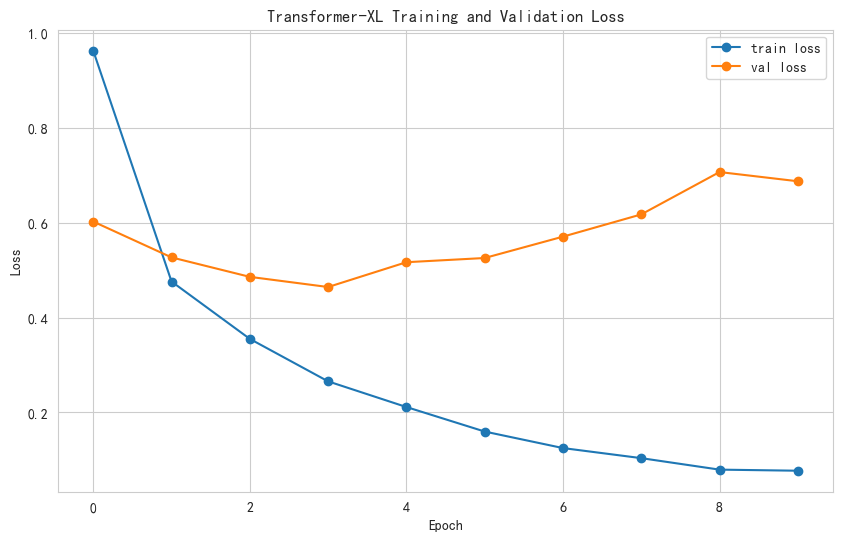

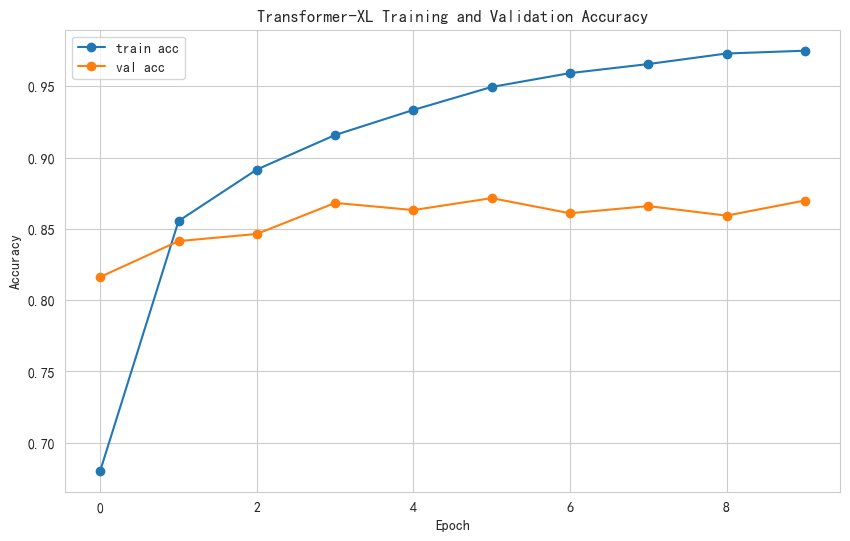

评估中: 100%|██████████| 56/56 [00:00<00:00, 135.66it/s]



测试损失: 0.5602, 测试准确率: 0.8693

分类报告:
              precision    recall  f1-score   support

     Culture     0.7215    0.7940    0.7560       199
   Education     0.8927    0.7940    0.8404       199
     Finance     0.9124    0.8894    0.9008       199
      Health     0.8522    0.8693    0.8607       199
          IT     0.8474    0.8090    0.8278       199
    Military     0.9323    0.8995    0.9156       199
     Recruit     0.8585    0.8844    0.8713       199
      Sports     0.9896    0.9598    0.9745       199
      Travel     0.8440    0.9246    0.8825       199

    accuracy                         0.8693      1791
   macro avg     0.8723    0.8693    0.8699      1791
weighted avg     0.8723    0.8693    0.8699      1791



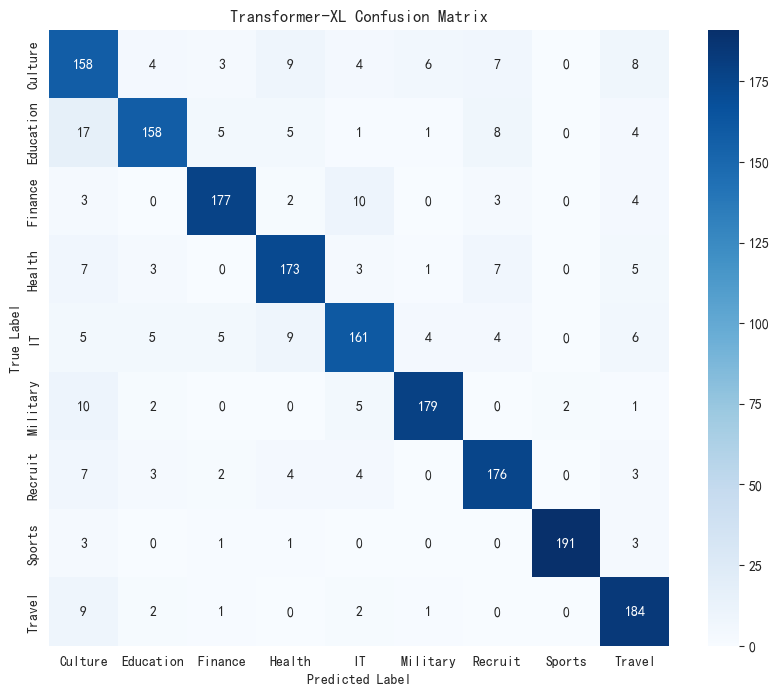

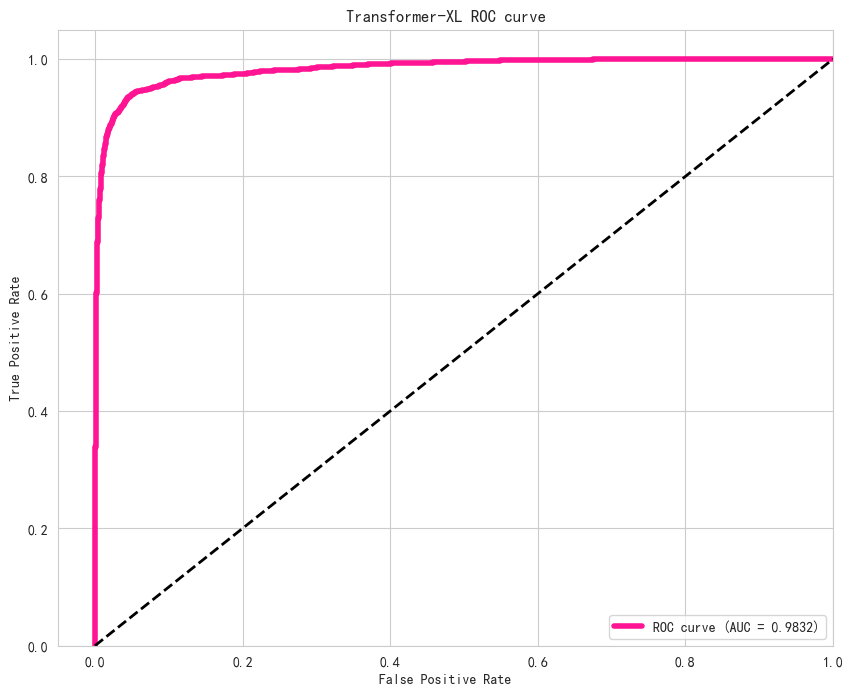

In [6]:
import os
import re
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import jieba
from collections import Counter

# 配置
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 支持中文显示
plt.rcParams['axes.unicode_minus'] = False


# 数据预处理类
class TextPreprocessor:
    def __init__(self, max_features=10000, max_len=128, stopwords_file=None):
        self.max_features = max_features
        self.max_len = max_len
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_counts = Counter()
        
        # 加载停用词
        self.stopwords = set()
        if stopwords_file:
            with open(stopwords_file, encoding='utf-8') as f:
                self.stopwords = set(f.read().strip().splitlines())

    def clean_text(self, text):
        """文本清洗，去除停用词和特殊字符"""
        text = re.sub(r'[^A-Za-z0-9\u4e00-\u9fa5]+', ' ', text)  # 保留中文、英文和数字
        text = text.strip()
        return text

    def tokenize(self, text):
        """分词并去除停用词"""
        text = self.clean_text(text)
        words = jieba.lcut(str(text))
        words = [word for word in words if word not in self.stopwords]
        return words

    def fit(self, texts):
        # 分词并统计词频
        for text in texts:
            self.word_counts.update(self.tokenize(text))

        # 选择最常见的词构建词典
        for word, _ in self.word_counts.most_common(self.max_features - 2):
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    def text_to_sequence(self, text):
        # 将文本转换为序列
        words = self.tokenize(text)
        sequence = [self.word2idx.get(word, self.word2idx['<UNK>']) for word in words]

        # 截断或填充到指定长度
        if len(sequence) < self.max_len:
            sequence = sequence + [self.word2idx['<PAD>']] * (self.max_len - len(sequence))
        else:
            sequence = sequence[:self.max_len]
        return sequence


# 数据集类
class TextDataset(Dataset):
    def __init__(self, texts, labels, preprocessor):
        self.texts = [preprocessor.text_to_sequence(text) for text in texts]
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.texts[idx], dtype=torch.long),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


# 相对位置编码类
class RelativePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len
        self.relative_embeddings = nn.Embedding(2 * max_len - 1, d_model)

    def forward(self, seq_len):
        range_vec = torch.arange(seq_len)
        distance_mat = range_vec[None, :] - range_vec[:, None]
        distance_mat_clipped = torch.clamp(distance_mat, -self.max_len + 1, self.max_len - 1)
        final_mat = distance_mat_clipped + self.max_len - 1
        final_mat = final_mat.to(next(self.parameters()).device)
        return self.relative_embeddings(final_mat)


# Transformer-XL编码器层
class TransformerXLEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1, max_len=128):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.relative_pos = RelativePositionalEncoding(d_model, max_len)
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, src, mem=None):
        seq_len, batch_size, _ = src.size()
        rel_pos_enc = self.relative_pos(seq_len)
        attn_output, attn_weights = self.self_attn(src, src, src, attn_mask=None, key_padding_mask=None)
        src = src + self.dropout1(attn_output)
        src = self.norm1(src)
        ff_output = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(ff_output)
        src = self.norm2(src)
        return src


# Transformer-XL模型类
class TransformerXLModel(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, d_ff, num_layers, num_classes, max_len=128, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=0)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, d_model))
        self.layers = nn.ModuleList([
            TransformerXLEncoderLayer(d_model, n_heads, d_ff, dropout, max_len)
            for _ in range(num_layers)
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, src):
        embedded = self.embedding(src)
        embedded = embedded + self.positional_encoding[:, :src.size(1), :]
        embedded = self.dropout(embedded)
        embedded = embedded.permute(1, 0, 2)
        for layer in self.layers:
            embedded = layer(embedded)
        embedded = embedded.permute(1, 0, 2)
        pooled = embedded.mean(dim=1)
        out = self.fc(pooled)
        return out


# 分类器类
class TransformerXLClassifier:
    def __init__(self, d_model=128, n_heads=8, d_ff=256, num_layers=2, dropout=0.1,
                 batch_size=32, max_features=10000, max_len=128, learning_rate=1e-3,
                 epochs=10, stopwords_file=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.preprocessor = TextPreprocessor(max_features=max_features, max_len=max_len, stopwords_file=stopwords_file)
        self.batch_size = batch_size
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_ff = d_ff
        self.num_layers = num_layers
        self.dropout = dropout
        self.max_len = max_len
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.label_encoder = LabelEncoder()
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
        self.best_val_acc = 0

    def prepare_data(self, data_dir):
        texts = []
        labels = []
        label_names = []  # 保存文件夹名称（类别名称）

        # 遍历数据集文件夹
        for folder in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder)
            if os.path.isdir(folder_path):
                label_names.append(folder)  # 记录类别名称
                for filename in os.listdir(folder_path):
                    file_path = os.path.join(folder_path, filename)
                    with open(file_path, encoding='gbk', errors='ignore') as f:
                        texts.append(f.read())
                        labels.append(folder)  # 使用文件夹名称作为标签

        # 标签编码
        self.label_encoder.fit(label_names)
        encoded_labels = self.label_encoder.transform(labels)

        # 构建词典
        self.preprocessor.fit(texts)
        vocab_size = len(self.preprocessor.word2idx)

        # 划分数据集
        X_train, X_temp, y_train, y_temp = train_test_split(
            texts, encoded_labels, test_size=0.2, random_state=42, stratify=encoded_labels
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
        )

        # 创建数据加载器
        self.train_loader = DataLoader(
            TextDataset(X_train, y_train, self.preprocessor),
            batch_size=self.batch_size, shuffle=True
        )
        self.val_loader = DataLoader(
            TextDataset(X_val, y_val, self.preprocessor),
            batch_size=self.batch_size
        )
        self.test_loader = DataLoader(
            TextDataset(X_test, y_test, self.preprocessor),
            batch_size=self.batch_size
        )

        num_classes = len(self.label_encoder.classes_)

        # 初始化模型
        self.model = TransformerXLModel(
            vocab_size=vocab_size,
            d_model=self.d_model,
            n_heads=self.n_heads,
            d_ff=self.d_ff,
            num_layers=self.num_layers,
            num_classes=num_classes,
            max_len=self.max_len,
            dropout=self.dropout
        ).to(self.device)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0
        for batch in tqdm(self.train_loader, desc='训练中'):
            self.optimizer.zero_grad()
            input_ids = batch['input_ids'].to(self.device)
            labels = batch['label'].to(self.device)
            outputs = self.model(input_ids)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        return total_loss / len(self.train_loader), correct / total

    def evaluate(self, data_loader):
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for batch in tqdm(data_loader, desc='评估中'):
                input_ids = batch['input_ids'].to(self.device)
                labels = batch['label'].to(self.device)
                outputs = self.model(input_ids)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())
        return (
            total_loss / len(data_loader),
            correct / total,
            all_preds,
            all_labels,
            np.array(all_probs)
        )

    def train_model(self, save_path='best_transformer_xl_model.pt'):
        for epoch in range(self.epochs):
            print(f"\nEpoch {epoch + 1}/{self.epochs}")
            print("-" * 10)
            train_loss, train_acc = self.train_epoch()
            val_loss, val_acc, _, _, _ = self.evaluate(self.val_loader)
            print(f"训练损失: {train_loss:.4f}, 训练准确率: {train_acc:.4f}")
            print(f"验证损失: {val_loss:.4f}, 验证准确率: {val_acc:.4f}")
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                torch.save(self.model.state_dict(), save_path)
                print(f"最佳模型已保存至 {save_path}")

    def plot_training_history(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_loss'], marker='o', label='train loss')
        plt.plot(self.history['val_loss'], marker='o', label='val loss')
        plt.title('Transformer-XL Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_acc'], marker='o', label='train acc')
        plt.plot(self.history['val_acc'], marker='o', label='val acc')
        plt.title('Transformer-XL Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

    def evaluate_and_plot(self, model_path='best_transformer_xl_model.pt'):
        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device)
        self.model.eval()
        
        test_loss, test_acc, y_pred, y_true, test_probs = self.evaluate(self.test_loader)
        print(f"\n测试损失: {test_loss:.4f}, 测试准确率: {test_acc:.4f}")

        # 转换回原始标签（文件夹名称）
        y_pred_labels = self.label_encoder.inverse_transform(y_pred)
        y_true_labels = self.label_encoder.inverse_transform(y_true)

        # 分类报告，使用真实的标签名称
        print("\n分类报告:")
        print(classification_report(y_true_labels, y_pred_labels, digits=4, target_names=self.label_encoder.classes_))

        # 混淆矩阵，使用真实的标签名称
        cm = confusion_matrix(y_true_labels, y_pred_labels, labels=self.label_encoder.classes_)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Transformer-XL Confusion Matrix')
        plt.show()

        # ROC曲线
        y_test_bin = label_binarize(y_true, classes=range(len(self.label_encoder.classes_)))
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), test_probs.ravel())
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})',
                 color='deeppink', linewidth=4)
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Transformer-XL ROC curve')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()



if __name__ == '__main__':
    data_dir = '/root/autodl-tmp/test/cn_news'  
    stopwords_file = '/root/autodl-tmp/test/baidu_stopwords.txt'  

    classifier = TransformerXLClassifier(
        d_model=128,
        n_heads=8,
        d_ff=256,
        num_layers=2,
        dropout=0.1,
        batch_size=32,
        max_features=10000,
        max_len=256,
        learning_rate=1e-3,
        epochs=10,
        stopwords_file=stopwords_file
    )

    classifier.prepare_data(data_dir)
    classifier.train_model(save_path='best_transformer_xl_model.pt')
    classifier.plot_training_history()
    classifier.evaluate_and_plot(model_path='best_transformer_xl_model.pt')